In [299]:
import sklearn.metrics
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import pandas as pd
import joblib
import numpy as np
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [300]:
def RSS(y, y_pred):
    return np.sum(np.square(np.subtract(y, y_pred)))

## We will try to predict the score of the whiskeys using the reviews. To do so we will first reduce the dimensionality using ```TruncatedSVD``` since it is supposed to work better on sparse data.
## Then we will fit the dataset using Ridge and Hubard and a simple NN.

## Then we will compare the results looking at the MSE of the models.

In [301]:
df = joblib.load('dataset/cleaned_dataset.joblib')
df.drop('Review', axis=1, inplace = True)
ID = df['Whiskey Name']
df.drop('Whiskey Name', axis=1, inplace=True)

In [302]:
type_col = [col for col in df.columns if 'Type_' in col]
name_col = [col for col in df.columns if 'Username_' in col]

drop_col = type_col + name_col + ['Score']

X_train, X_test, y_train, y_test = train_test_split(df.drop(drop_col, axis=1), df['Score'], test_size=0.3)
y_scaling = StandardScaler()

y_train = y_scaling.fit_transform(np.array(y_train).reshape(-1,1))
y_test = y_scaling.transform(np.array(y_test).reshape(-1,1))

# 0. Baseline

In [303]:
MAE_baseline = []
MSE_baseline = []
RSS_baseline = []

MAE_baseline.append(mean_absolute_error(np.ones(len(y_test))*y_train.mean(), y_test))
MSE_baseline.append(mean_squared_error(np.ones(len(y_test))*y_train.mean(), y_test))
RSS_baseline.append(RSS(y_test, y_train.mean()))

In [304]:
MSE_baseline

[1.036431365302328]

# 1. Ridge regression

In [305]:
linReg = Pipeline([
    ('scaling', StandardScaler()),
    ('pca', TruncatedSVD()),
    ('linreg', Ridge())])

param_grid = [{
    'scaling': ['passthrough', StandardScaler(), RobustScaler()],
    'pca': ['passthrough', TruncatedSVD(50), TruncatedSVD(75), TruncatedSVD(100)],
    'linreg__alpha': np.logspace(-4, 4, num=20),
}]

# From: https://stackoverflow.com/questions/25125194/how-to-get-both-mse-and-r2-from-a-sklearn-gridsearchcv

gs_ridge = GridSearchCV(estimator=linReg, param_grid=param_grid, return_train_score=True, scoring=['neg_mean_squared_error', 'r2'], refit='r2', n_jobs=-1)

In [306]:
gs_ridge.fit(X_train, y_train);

In [307]:
gs_ridge.best_estimator_

Pipeline(steps=[('scaling', 'passthrough'), ('pca', 'passthrough'),
                ('linreg', Ridge(alpha=1.623776739188721))])

In [308]:
passthrough = gs_ridge.cv_results_['params'][0]['scaling']
standard = gs_ridge.cv_results_['params'][1]['scaling']
robust = gs_ridge.cv_results_['params'][2]['scaling']
best_params_ridge = []

score = {}
for k in ['passthrough', 'standard', 'robust']:
    score[k] = {'alpha': [], 'train':[], 'test':[], 'std_train': [], 'std_test': []}

for ind, param in enumerate(gs_ridge.cv_results_['params']):
    if gs_ridge.cv_results_['params'][ind]['pca'] == gs_ridge.best_params_['pca']:
        if param['scaling'] == passthrough:
            key = 'passthrough'
        elif param['scaling'] == standard:
            key = 'standard'
        elif param['scaling'] == robust:
            key = 'robust'
        else:
            key = 'other'

        if param['scaling'] == gs_ridge.best_params_['scaling'] and gs_ridge.cv_results_['params'][ind]['linreg__alpha'] == gs_ridge.best_params_['linreg__alpha']:
            best_params_ridge = [param['scaling'], gs_ridge.best_params_['linreg__alpha'], gs_ridge.cv_results_['mean_train_neg_mean_squared_error'][ind]]

        score[key]['alpha'].append(gs_ridge.cv_results_['params'][ind]['linreg__alpha'])
        score[key]['train'].append(gs_ridge.cv_results_['mean_train_neg_mean_squared_error'][ind])
        score[key]['test'].append(gs_ridge.cv_results_['mean_test_neg_mean_squared_error'][ind])
        score[key]['std_train'].append(gs_ridge.cv_results_['std_train_neg_mean_squared_error'][ind])
        score[key]['std_test'].append(gs_ridge.cv_results_['std_test_neg_mean_squared_error'][ind])

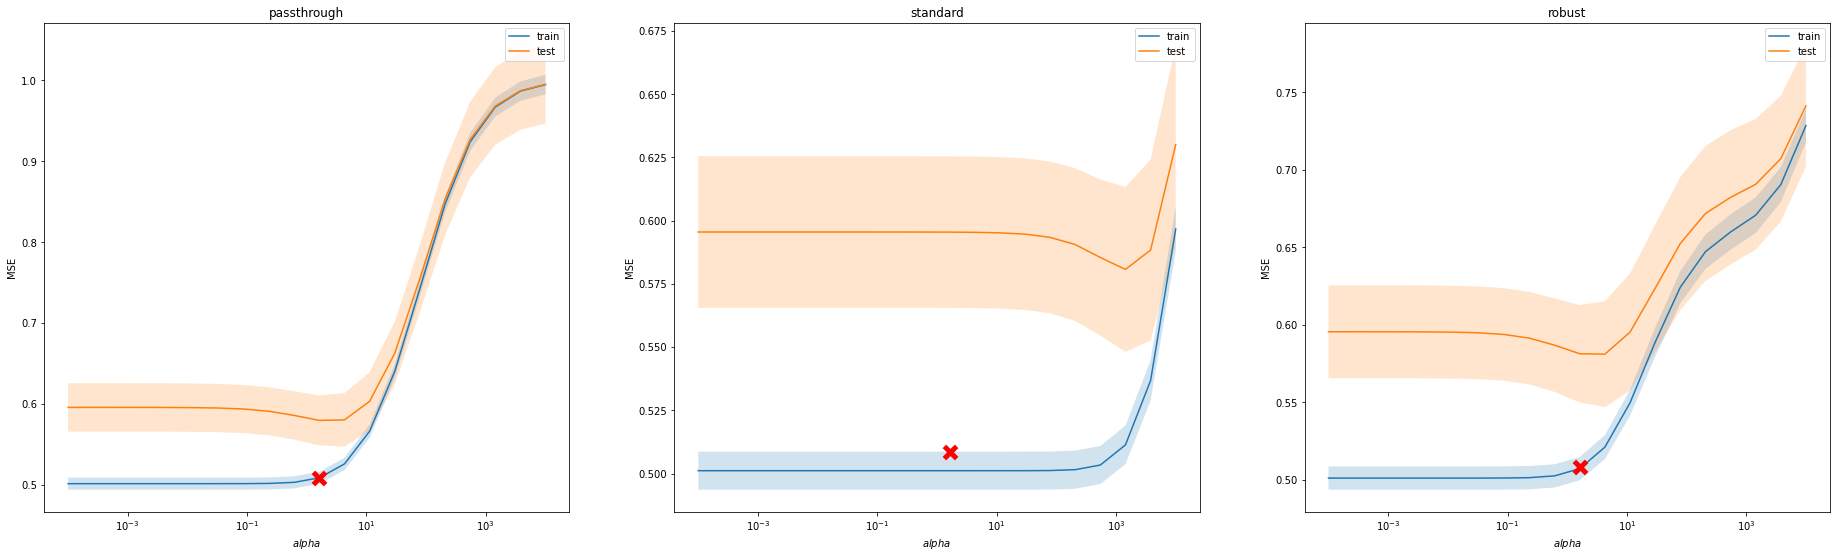

In [309]:
fig, ax = plt.subplots(1,3, figsize=(32,9))
flat_ax = np.ravel(ax)

for i, k in enumerate(['passthrough', 'standard', 'robust']):

    alphas = score[k]['alpha']
    mean_tr = -np.array(score[k]['train'])
    std_tr = np.array(score[k]['std_train'])
    mean_te = -np.array(score[k]['test'])
    std_te =  np.array(score[k]['std_test'])

    flat_ax[i].semilogx(alphas, mean_tr, label='train')
    flat_ax[i].semilogx(alphas, mean_te, label='test')

    flat_ax[i].fill_between(alphas, mean_tr-std_tr, mean_tr+std_tr, alpha=0.2)
    flat_ax[i].fill_between(alphas, mean_te-std_te, mean_te+std_te, alpha=0.2)
    flat_ax[i].set_title(k)
    flat_ax[i].set_xlabel('$alpha$')
    flat_ax[i].set_ylabel('MSE')
    flat_ax[i].legend()
    flat_ax[i].scatter(best_params_ridge[1], -best_params_ridge[2], marker='x', c='red', zorder=10, s=150, linewidth=5)


# 2. Huber Regressor

In [310]:
linReg = Pipeline([
    ('scaling', StandardScaler()),
    ('pca', TruncatedSVD()),
    ('linreg', HuberRegressor(epsilon=1.35))])

param_grid = [{
    'scaling': ['passthrough', StandardScaler(), RobustScaler()],
    'pca': ['passthrough', TruncatedSVD(50), TruncatedSVD(75), TruncatedSVD(100)],
    'linreg__alpha': np.logspace(-4, 4, num=10),
}]

# From: https://stackoverflow.com/questions/25125194/how-to-get-both-mse-and-r2-from-a-sklearn-gridsearchcv

gs_huber = GridSearchCV(estimator=linReg, param_grid=param_grid, return_train_score=True, scoring=['neg_mean_squared_error', 'r2'], refit='r2', n_jobs=-1)

In [324]:
gs_huber.fit(X_train, y_train);

C:\Users\loic\anaconda3\envs\EPFL_ML_updated\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\loic\anaconda3\envs\EPFL_ML_updated\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [325]:
gs_huber.best_estimator_

Pipeline(steps=[('scaling', 'passthrough'), ('pca', 'passthrough'),
                ('linreg', HuberRegressor(alpha=0.3593813663804626))])

In [326]:
passthrough = gs_huber.cv_results_['params'][0]['scaling']
standard = gs_huber.cv_results_['params'][1]['scaling']
robust = gs_huber.cv_results_['params'][2]['scaling']
best_params_huber = []

score = {}
for k in ['passthrough', 'standard', 'robust']:
    score[k] = {'alpha': [], 'train':[], 'test':[], 'std_train': [], 'std_test': []}

for ind, param in enumerate(gs_huber.cv_results_['params']):
    if gs_huber.cv_results_['params'][ind]['pca'] == gs_huber.best_params_['pca']:
        if param['scaling'] == passthrough:
            key = 'passthrough'
        elif param['scaling'] == standard:
            key = 'standard'
        elif param['scaling'] == robust:
            key = 'robust'
        else:
            key = 'other'

        if param['scaling'] == gs_huber.best_params_['scaling'] and gs_huber.cv_results_['params'][ind]['linreg__alpha'] == gs_huber.best_params_['linreg__alpha']:
            best_params_huber = [param['scaling'], gs_huber.best_params_['linreg__alpha'], gs_huber.cv_results_['mean_train_neg_mean_squared_error'][ind]]

        score[key]['alpha'].append(gs_huber.cv_results_['params'][ind]['linreg__alpha'])
        score[key]['train'].append(gs_huber.cv_results_['mean_train_neg_mean_squared_error'][ind])
        score[key]['test'].append(gs_huber.cv_results_['mean_test_neg_mean_squared_error'][ind])
        score[key]['std_train'].append(gs_huber.cv_results_['std_train_neg_mean_squared_error'][ind])
        score[key]['std_test'].append(gs_huber.cv_results_['std_test_neg_mean_squared_error'][ind])

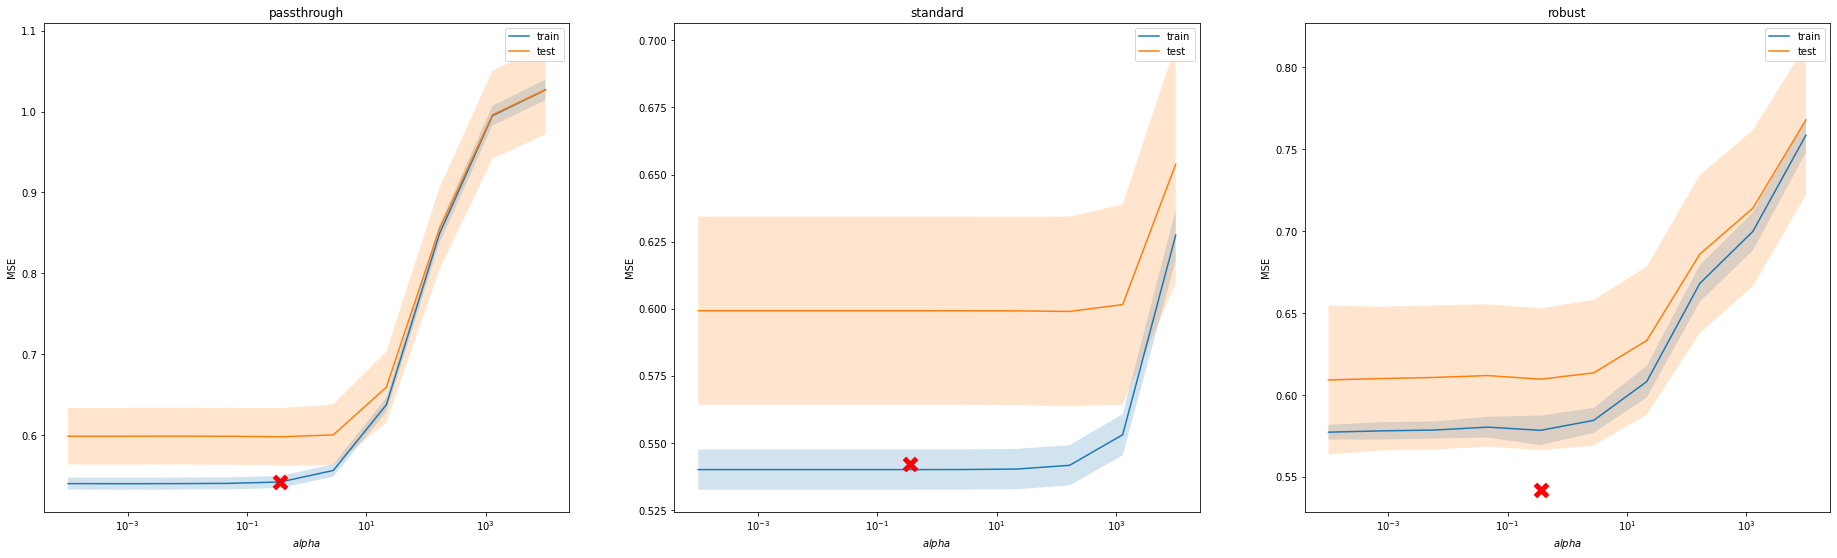

In [327]:
fig, ax = plt.subplots(1,3, figsize=(32,9))
flat_ax = np.ravel(ax)

for i, k in enumerate(['passthrough', 'standard', 'robust']):

    alphas = score[k]['alpha']
    mean_tr = -np.array(score[k]['train'])
    std_tr = np.array(score[k]['std_train'])
    mean_te = -np.array(score[k]['test'])
    std_te =  np.array(score[k]['std_test'])

    flat_ax[i].semilogx(alphas, mean_tr, label='train')
    flat_ax[i].semilogx(alphas, mean_te, label='test')

    flat_ax[i].fill_between(alphas, mean_tr-std_tr, mean_tr+std_tr, alpha=0.2)
    flat_ax[i].fill_between(alphas, mean_te-std_te, mean_te+std_te, alpha=0.2)
    flat_ax[i].set_title(k)
    flat_ax[i].set_xlabel('$alpha$')
    flat_ax[i].set_ylabel('MSE')
    flat_ax[i].legend()
    flat_ax[i].scatter(best_params_huber[1], -best_params_huber[2], marker='x', c='red', zorder=10, s=150, linewidth=5)

# 3. Neural Network

In [328]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Normalization

In [329]:
model = keras.Sequential([
    Normalization(),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(256, activation='relu'),
    Dropout(0.1),
    Dense(512, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='linear')
])

model.compile(optimizer='sgd', loss='mean_squared_error', metrics=['mse', 'mae'])

In [330]:
history = model.fit(
    x=X_train, y=y_train,
    validation_split=0.3, batch_size=64, epochs=50,
    shuffle=True # Shuffle training samples
)

Epoch 1/50
81/81 [==============================] - 1s 6ms/step - loss: 1.0188 - mse: 1.0188 - mae: 0.7236 - val_loss: 0.9417 - val_mse: 0.9417 - val_mae: 0.7117
Epoch 2/50
81/81 [==============================] - 0s 4ms/step - loss: 1.0121 - mse: 1.0121 - mae: 0.7210 - val_loss: 0.9351 - val_mse: 0.9351 - val_mae: 0.7104
Epoch 3/50
81/81 [==============================] - 0s 4ms/step - loss: 1.0030 - mse: 1.0030 - mae: 0.7187 - val_loss: 0.9243 - val_mse: 0.9243 - val_mae: 0.6999
Epoch 4/50
81/81 [==============================] - 0s 4ms/step - loss: 0.9939 - mse: 0.9939 - mae: 0.7116 - val_loss: 0.9140 - val_mse: 0.9140 - val_mae: 0.7012
Epoch 5/50
81/81 [==============================] - 0s 3ms/step - loss: 0.9789 - mse: 0.9789 - mae: 0.7077 - val_loss: 0.8960 - val_mse: 0.8960 - val_mae: 0.6819
Epoch 6/50
81/81 [==============================] - 0s 4ms/step - loss: 0.9586 - mse: 0.9586 - mae: 0.6959 - val_loss: 0.8732 - val_mse: 0.8732 - val_mae: 0.6746
Epoch 7/50
81/81 [==========

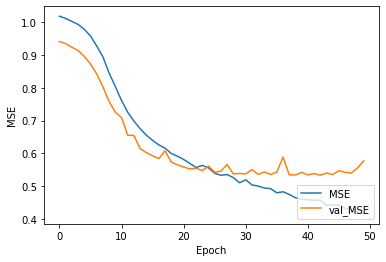

In [331]:
plt.plot(history.history['mse'], label='MSE')
plt.plot(history.history['val_mse'], label = 'val_MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
#plt.ylim([0., 0.25])
plt.legend(loc='lower right')

In [332]:
loss_NN, mse_NN, mae_NN = model.evaluate(X_test, y_test, batch_size=32)

99/99 [==============================] - 0s 2ms/step - loss: 0.6451 - mse: 0.6451 - mae: 0.5218


<AxesSubplot:>

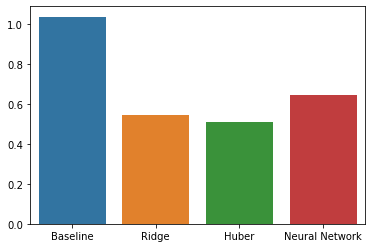

In [333]:
sns.barplot(x=['Baseline', 'Ridge', 'Huber', 'Neural Network'],y=[MSE_baseline[0], -best_params_huber[2],-best_params_ridge[2], mse_NN])


## The three models are performing similarly, and better than the baseline. But the result is still not great.

## If we look at the distribution of scores on a histogram or violin plot, the result doesn't seems bad, however looking at the linear relationship between the real value and the predicted value, we realise that the models are very bad at fitting the low scores, which make sense since the population of low score is very small.

## But more surprising they also have a wide distribution of score around the central value. If we look at the true value of the score it is a gaussian centered around 80 with a width of around 10: looking at the distribution of the variation between predicted and true value, the width of the gaussian is similar to the width of the true distribution, therefore the prediction is not good.

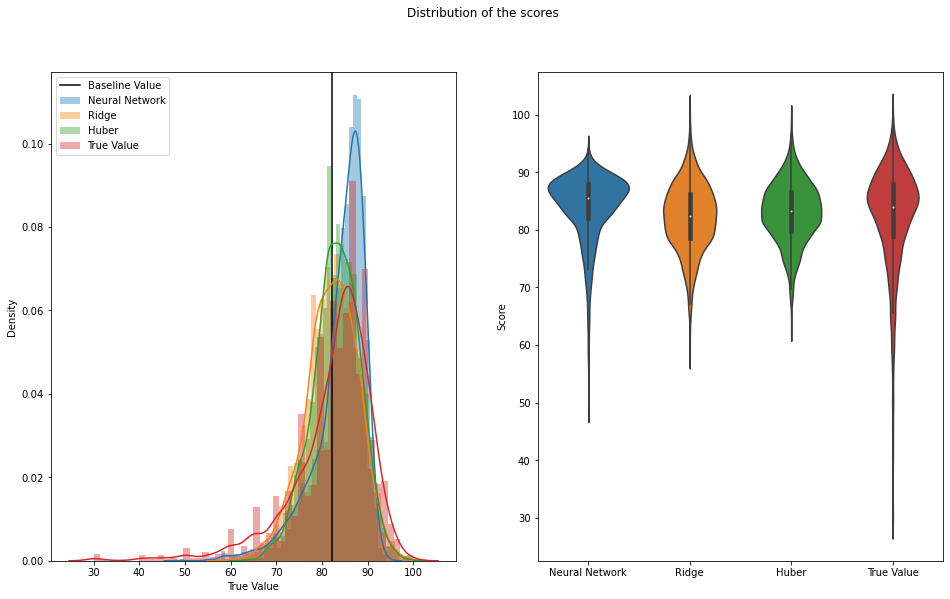

In [334]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

fig, ax = plt.subplots(1,2, figsize=(16,9))

df_result = pd.DataFrame({'Neural Network': y_scaling.inverse_transform(model.predict(X_test).reshape(-1, 1)).ravel(),
           'Ridge': y_scaling.inverse_transform(gs_ridge.predict(X_test).reshape(-1, 1)).ravel(),
           'Huber': y_scaling.inverse_transform(gs_huber.predict(X_test).reshape(-1, 1)).ravel(),
           'True Value': y_scaling.inverse_transform(y_test.reshape(-1, 1)).ravel()})

ax[0].axvline(y_scaling.inverse_transform(y_train).reshape(-1, 1).mean(), color='k', label='Baseline Value')
sns.distplot(df_result['Neural Network'], label='Neural Network', ax=ax[0])
sns.distplot(df_result['Ridge'], label='Ridge', ax=ax[0])
sns.distplot(df_result['Huber'], label='Huber', ax=ax[0])
sns.distplot(df_result['True Value'], label='True Value', ax=ax[0])

sns.violinplot(data=df_result, ax=ax[1])
ax[1].set_xticks([0,1,2,3], ['Neural Network', 'Ridge', 'Huber', 'True Value'])
ax[1].set_ylabel('Score')

fig.suptitle('Distribution of the scores')
ax[0].legend();

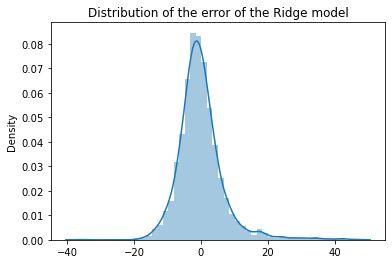

In [335]:
sns.distplot(df_result['Ridge'] - df_result['True Value'])
plt.title('Distribution of the error of the Ridge model');

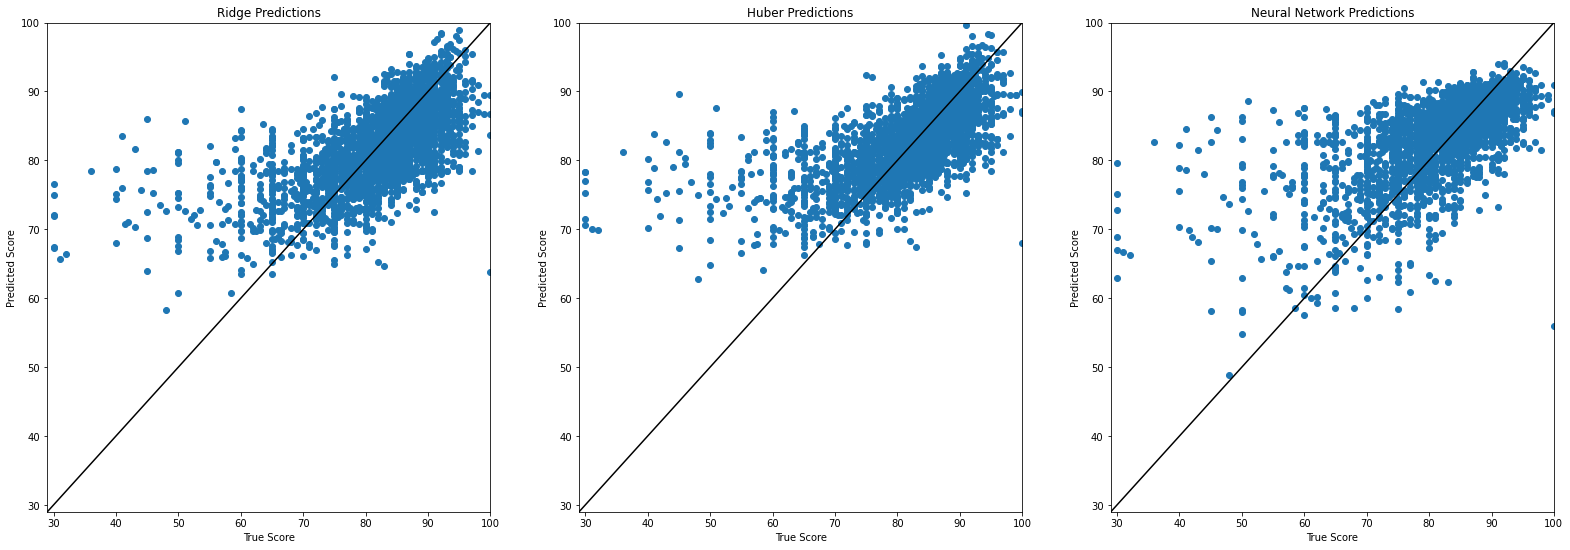

In [336]:
fig, ax = plt.subplots(1,3, figsize=(27,9))

ax[0].scatter(data=df_result, x='True Value', y='Ridge')
ax[1].scatter(data=df_result, x='True Value', y='Huber')
ax[2].scatter(data=df_result, x='True Value', y='Neural Network')

ax[0].set_title('Ridge Predictions')
ax[1].set_title('Huber Predictions')
ax[2].set_title('Neural Network Predictions')

for i in [0,1,2]:

    ax[i].plot([29,100], [29,100], c='k')

    ax[i].set_xlim(29,100)
    ax[i].set_ylim(29,100)
    ax[i].set_ylabel('Predicted Score')
    ax[i].set_xlabel('True Score')